# PyTorch GANSynth

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Sample Generator'

Mounted at /content/drive
/content/drive/My Drive/Sample Generator


In [2]:
#@title Models
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def scalar_concat(tensor, scalar, dim=1):
        out_shape = list(tensor.shape)
        out_shape[dim] = 1
        return torch.cat([tensor,
                          torch.ones(out_shape).to(device) * scalar],
                          dim=dim)


class Pixel_norm(nn.Module):
    """ Pixel normalization. Мегапиксель сократить """
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
        # self.eps = nn.Parameter(torch.Tensor(eps), requires_grad=False)

    def forward(self, x):
        return x / torch.sqrt(torch.mean(
            torch.square(x), axis=1, keepdims=True) + self.eps)
    

class Minibatch_std(nn.Module):
    """ Output shape: (N, C + 1, W, H) """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        var = torch.var(x, dim=0, keepdim=False)
        mean = torch.mean(torch.sqrt(var + 1e-6))
        return scalar_concat(x, mean, 1)
    

class Generator_1(nn.Module):
    """ Transposed conv2d + batch_norm """
    def __init__(self):
        super(Generator_1, self).__init__()

        def block(in_channels, out_channels, upsample=True):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False)]
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.ConvTranspose2d(out_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if upsample:
                layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
            return layers

        self.model = nn.Sequential(
            nn.ConvTranspose2d(hyperparams['latent_dim'], 256, [1, 16], stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output shape (None, 256, 2, 32)
            *block(256, 256), # output shape (None, 256, 4, 64)
            *block(256, 256), # output shape (None, 256, 8, 128)
            *block(256, 256), # output shape (None, 256, 16, 256)
            *block(256, 128), # output shape (None, 128, 32, 512)
            *block(128, 64), # output shape (None, 64, 64, 1024)
            *block(64, 32, upsample=False), # output shape (None, 32, 64, 1024)
            # nn.Conv2d(32, 2, [1, 1], stride=1, bias=False),
            nn.ConvTranspose2d(32, 2, [1, 1], stride=1, bias=False),
            nn.Tanh()
            )

    def forward(self, z):
        img = z.view(-1, 256, 1, 1)
        img = self.model(img)
        return img

    
class Generator_2(nn.Module):
    """ Conv2d + pixel_norm """
    def __init__(self):
        super(Generator_2, self).__init__()

        def block(in_channels, out_channels, upsample=True):
            layers = [nn.Conv2d(in_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(Pixel_norm())
            layers.append(nn.Conv2d(out_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(Pixel_norm())
            if upsample:
                layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
            return layers

        self.model = nn.Sequential(
            nn.ZeroPad2d((15, 15, 0, 0)),
            nn.Conv2d(256, 256, [1, 16], stride=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            Pixel_norm(),
            nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            Pixel_norm(),
            nn.Upsample(scale_factor=2, mode='nearest'), # output shape (None, 256, 2, 32)
            *block(256, 256), # output shape (None, 256, 4, 64)
            *block(256, 256), # output shape (None, 256, 8, 128)
            *block(256, 256), # output shape (None, 256, 16, 256)
            *block(256, 128), # output shape (None, 128, 32, 512)
            *block(128, 64), # output shape (None, 64, 64, 1024)
            *block(64, 32, upsample=False), # output shape (None, 32, 64, 1024)
            nn.Conv2d(32, 2, [1, 1], stride=1, bias=False),
            nn.Tanh()
            )

    def forward(self, z):
        img = z.view(-1, 256, 1, 1)
        img = self.model(img)
        return img
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def block(in_channels, out_channels, downsample=True):
            layers = [nn.Conv2d(in_channels, out_channels, [3, 3], stride=1, padding=[1, 1])]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_channels, out_channels, [3, 3], stride=1, padding=[1, 1]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if downsample:
                layers.append(nn.AvgPool2d(2, 2))
            return layers

        self.model = nn.Sequential(
            nn.Conv2d(2, 32, [1, 1], stride=1),
            *block(32, 32), # output shape (None, 32, 32, 512)
            *block(32, 64), # output shape (None, 64, 16, 256)
            *block(64, 128), # output shape (None, 128, 8, 128)
            *block(128, 256), # output shape (None, 256, 4, 64)
            *block(256, 256), # output shape (None, 256, 2, 32)
            *block(256, 256), # output shape (None, 256, 1, 16)
            Minibatch_std(), # output shape (None, 257, 1, 16)
            *block(257, 256, downsample=False), # output shape (None, 256, 1, 16)
            nn.Flatten(),
            nn.Linear(256*1*16, 1),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [3]:
#@title Data Normalizer
import numpy as np
import tensorflow as tf

class DataNormalizer(object):
    def __init__(self, dataloader, margin_mag = 0.8, margin_IF = 1.0):
        self.dataloader = dataloader
        self._margin_mag = margin_mag
        self._margin_IF = margin_IF

        self._range_normalizer(magnitude_margin=self._margin_mag, IF_margin=self._margin_IF)
        print("s_a:", self.s_a )
        print("s_b:", self.s_b )
        print("p_a:", self.p_a)
        print("p_b:", self.p_b)

    def _range_normalizer(self, magnitude_margin, IF_margin):

        min_spec = 10000
        max_spec = -10000
        min_IF = 10000
        max_IF = -10000

        spec = self.dataloader[:, :, :, 0]
        IF = self.dataloader[:, :, :, 1]

        if tf.reduce_min(spec).numpy() < min_spec: min_spec=tf.reduce_min(spec).numpy()
        if tf.reduce_max(spec).numpy() > max_spec: max_spec=tf.reduce_max(spec).numpy()

        if tf.reduce_min(IF).numpy() < min_IF: min_IF=tf.reduce_min(IF).numpy()
        if tf.reduce_max(IF).numpy() > max_IF: max_IF=tf.reduce_max(IF).numpy()
    
        self.s_a = magnitude_margin * (2.0 / (max_spec - min_spec))
        self.s_b = magnitude_margin * (-2.0 * min_spec / (max_spec - min_spec) - 1.0)
        
        self.p_a = IF_margin * (2.0 / (max_IF - min_IF))
        self.p_b = IF_margin * (-2.0 * min_IF / (max_IF - min_IF) - 1.0)

    def normalize(self, feature_map):

        a = np.asarray([self.s_a, self.p_a])[None, None, None, :]
        b = np.asarray([self.s_b, self.p_b])[None, None, None, :]
        a = tf.constant(a, dtype=feature_map.dtype)
        b = tf.constant(b, dtype=feature_map.dtype)

        feature_map = feature_map * a + b
        
        print("spec Max",tf.reduce_max(feature_map[:,:,:,0]))
        print("spec min",tf.reduce_min(feature_map[:,:,:,0]))
        print("IF Max",tf.reduce_max(feature_map[:,:,:,1]))
        print("IF min",tf.reduce_min(feature_map[:,:,:,1]))

        return feature_map

    def denormalize(self, feature_map, params = None):
        if params is not None:
            s_a, s_b, p_a, p_b = params
        else:
            s_a, s_b, p_a, p_b = self.s_a, self.s_b, self.p_a, self.p_b
        
        spec = feature_map[:, :, :, 0]
        IF = feature_map[:, :, :, 1]

        spec = (spec - s_b) / s_a
        IF = (IF - p_b) / p_a

        print("spec Max",tf.reduce_max(spec))
        print("spec min",tf.reduce_min(spec))
        print("IF Max",tf.reduce_max(IF))
        print("IF min",tf.reduce_min(IF))

        return tf.stack([spec, IF], axis=-1)

In [4]:
#@title specgrams_helper_onl
# Copyright 2020 The Magenta Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Helper object for transforming audio to spectra.

Handles transformations between waveforms, stfts, spectrograms,
mel-spectrograms, and instantaneous frequency (specgram).
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from spectral_ops import *
# from magenta.models.gansynth.lib import spectral_ops
import numpy as np
import tensorflow.compat.v1 as tf


class SpecgramsHelper(object):
    """Helper functions to compute specgrams."""

    def __init__(self, audio_length, spec_shape, overlap,
               sample_rate, mel_downscale, ifreq=True, discard_dc=True):
        self._audio_length = audio_length
        self._spec_shape = spec_shape
        self._overlap = overlap
        self._sample_rate = sample_rate
        self._mel_downscale = mel_downscale
        self._ifreq = ifreq
        self._discard_dc = discard_dc

        self._nfft, self._nhop = self._get_nfft_nhop()
        self._pad_l, self._pad_r = self._get_padding()

        self._eps = 1.0e-6

    def _safe_log(self, x):
        return tf.log(x + self._eps)

    def _get_nfft_nhop(self):
        n_freq_bins = self._spec_shape[1]
        # Power of two only has 1 nonzero in binary representation
        is_power_2 = bin(n_freq_bins).count('1') == 1
        if not is_power_2:
            raise ValueError('Wrong spec_shape. Number of frequency bins must be '
                           'a power of 2, not %d' % n_freq_bins)
        nfft = n_freq_bins * 2
        nhop = int((1. - self._overlap) * nfft)
        return (nfft, nhop)

    def _get_padding(self):
        """Infer left and right padding for STFT."""
        n_samps_inv = self._nhop * (self._spec_shape[0] - 1) + self._nfft
        if n_samps_inv < self._audio_length:
            raise ValueError('Wrong audio length. Number of ISTFT samples, %d, should'
                           ' be less than audio lengeth %d' % self._audio_length)

        # For Nsynth dataset, we are putting all padding in the front
        # This causes edge effects in the tail
        padding = n_samps_inv - self._audio_length
        padding_l = padding
        padding_r = padding - padding_l
        return padding_l, padding_r

    def waves_to_stfts(self, waves):
        """Convert from waves to complex stfts.

        Args:
          waves: Tensor of the waveform, shape [batch, time, 1].

        Returns:
          stfts: Complex64 tensor of stft, shape [batch, time, freq, 1].
        """
        waves_padded = tf.pad(waves, [[0, 0], [self._pad_l, self._pad_r], [0, 0]])
        stfts = tf.signal.stft(
            waves_padded[:, :, 0],
            frame_length=self._nfft,
            frame_step=self._nhop,
            fft_length=self._nfft,
            pad_end=False)[:, :, :, tf.newaxis]
        stfts = stfts[:, :, 1:] if self._discard_dc else stfts[:, :, :-1]
        stft_shape = stfts.get_shape().as_list()[1:3]
        if tuple(stft_shape) != tuple(self._spec_shape):
            raise ValueError(
              'Spectrogram returned the wrong shape {}, is not the same as the '
              'constructor spec_shape {}.'.format(stft_shape, self._spec_shape))
        return stfts

    def stfts_to_waves(self, stfts):
        """Convert from complex stfts to waves.

        Args:
          stfts: Complex64 tensor of stft, shape [batch, time, freq, 1].

        Returns:
          waves: Tensor of the waveform, shape [batch, time, 1].
        """
        dc = 1 if self._discard_dc else 0
        nyq = 1 - dc
        stfts = tf.pad(stfts, [[0, 0], [0, 0], [dc, nyq], [0, 0]])
        waves_resyn = tf.signal.inverse_stft(
            stfts=stfts[:, :, :, 0],
            frame_length=self._nfft,
            frame_step=self._nhop,
            fft_length=self._nfft,
            window_fn=tf.signal.inverse_stft_window_fn(
                frame_step=self._nhop))[:, :, tf.newaxis]
        # Python does not allow rslice of -0
        if self._pad_r == 0:
            return waves_resyn[:, self._pad_l:]
        else:
            return waves_resyn[:, self._pad_l:-self._pad_r]

    def stfts_to_specgrams(self, stfts):
        """Converts stfts to specgrams.

        Args:
          stfts: Complex64 tensor of stft, shape [batch, time, freq, 1].

        Returns:
          specgrams: Tensor of log magnitudes and instantaneous frequencies,
            shape [batch, time, freq, 2].
        """
        stfts = stfts[:, :, :, 0]

        logmag = self._safe_log(tf.abs(stfts))

        phase_angle = tf.angle(stfts)
        if self._ifreq:
            p = instantaneous_frequency(phase_angle)
        else:
            p = phase_angle / np.pi

        return tf.concat(
                [logmag[:, :, :, tf.newaxis], p[:, :, :, tf.newaxis]], axis=-1)

    def specgrams_to_stfts(self, specgrams):
        """Converts specgrams to stfts.

        Args:
          specgrams: Tensor of log magnitudes and instantaneous frequencies,
            shape [batch, time, freq, 2].

        Returns:
          stfts: Complex64 tensor of stft, shape [batch, time, freq, 1].
        """
        logmag = specgrams[:, :, :, 0]
        p = specgrams[:, :, :, 1]

        mag = tf.exp(logmag)

        if self._ifreq:
            phase_angle = tf.cumsum(p * np.pi, axis=-2)
        else:
            phase_angle = p * np.pi

        return polar2rect(mag, phase_angle)[:, :, :, tf.newaxis]

    def _linear_to_mel_matrix(self):
        """Get the mel transformation matrix."""
        num_freq_bins = self._nfft // 2
        lower_edge_hertz = 0.0
        upper_edge_hertz = self._sample_rate / 2.0
        num_mel_bins = num_freq_bins // self._mel_downscale
        return linear_to_mel_weight_matrix(
            num_mel_bins, num_freq_bins, self._sample_rate, lower_edge_hertz,
            upper_edge_hertz)

    def _mel_to_linear_matrix(self):
        """Get the inverse mel transformation matrix."""
        m = self._linear_to_mel_matrix()
        m_t = np.transpose(m)
        p = np.matmul(m, m_t)
        d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
        return np.matmul(m_t, np.diag(d))

    def specgrams_to_melspecgrams(self, specgrams):
        """Converts specgrams to melspecgrams.

        Args:
          specgrams: Tensor of log magnitudes and instantaneous frequencies,
            shape [batch, time, freq, 2].

        Returns:
          melspecgrams: Tensor of log magnitudes and instantaneous frequencies,
            shape [batch, time, freq, 2], mel scaling of frequencies.
        """
        if self._mel_downscale is None:
            return specgrams

        logmag = specgrams[:, :, :, 0]
        p = specgrams[:, :, :, 1]

        mag2 = tf.exp(2.0 * logmag)
        phase_angle = tf.cumsum(p * np.pi, axis=-2)
        
        l2mel = tf.cast(self._linear_to_mel_matrix(), dtype=tf.float32)
        #l2mel = tf.to_float(self._linear_to_mel_matrix())
        logmelmag2 = self._safe_log(tf.tensordot(mag2, l2mel, 1))
        mel_phase_angle = tf.tensordot(phase_angle, l2mel, 1)
        mel_p = instantaneous_frequency(mel_phase_angle)

        return tf.concat(
            [logmelmag2[:, :, :, tf.newaxis], mel_p[:, :, :, tf.newaxis]], axis=-1)

    def melspecgrams_to_specgrams(self, melspecgrams):
        """Converts melspecgrams to specgrams.

        Args:
          melspecgrams: Tensor of log magnitudes and instantaneous frequencies,
            shape [batch, time, freq, 2], mel scaling of frequencies.

        Returns:
          specgrams: Tensor of log magnitudes and instantaneous frequencies,
            shape [batch, time, freq, 2].
        """
        if self._mel_downscale is None:
            return melspecgrams

        logmelmag2 = melspecgrams[:, :, :, 0]
        mel_p = melspecgrams[:, :, :, 1]

        mel2l = tf.to_float(self._mel_to_linear_matrix())
        mag2 = tf.tensordot(tf.exp(logmelmag2), mel2l, 1)
        logmag = 0.5 * self._safe_log(mag2)
        mel_phase_angle = tf.cumsum(mel_p * np.pi, axis=-2)
        phase_angle = tf.tensordot(mel_phase_angle, mel2l, 1)
        p = instantaneous_frequency(phase_angle)

        return tf.concat(
            [logmag[:, :, :, tf.newaxis], p[:, :, :, tf.newaxis]], axis=-1)

    def stfts_to_melspecgrams(self, stfts):
        """Converts stfts to mel-spectrograms."""
        return self.specgrams_to_melspecgrams(self.stfts_to_specgrams(stfts))

    def melspecgrams_to_stfts(self, melspecgrams):
        """Converts mel-spectrograms to stfts."""
        return self.specgrams_to_stfts(self.melspecgrams_to_specgrams(melspecgrams))

    def waves_to_specgrams(self, waves):
        """Converts waves to spectrograms."""
        return self.stfts_to_specgrams(self.waves_to_stfts(waves))

    def specgrams_to_waves(self, specgrams):
        """Converts spectrograms to stfts."""
        return self.stfts_to_waves(self.specgrams_to_stfts(specgrams))

    def waves_to_melspecgrams(self, waves):
        """Converts waves to mel-spectrograms."""
        return self.stfts_to_melspecgrams(self.waves_to_stfts(waves))

    def melspecgrams_to_waves(self, melspecgrams):
        """Converts mel-spectrograms to stfts."""
        return self.stfts_to_waves(self.melspecgrams_to_stfts(melspecgrams))

In [5]:
import argparse
import os
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
with open('train_data.npy', 'rb') as f:
    train_data = np.load(f,
                         #allow_pickle=True, 
                        )
f.close()
print(train_data.shape)

spec_gr = SpecgramsHelper(audio_length=16000,
                          spec_shape=(64, 1024),
                          overlap=0.75,
                          sample_rate=44100,
                          mel_downscale=1,
                          ifreq=True,
                          discard_dc=True)

melgrams = spec_gr.waves_to_melspecgrams(train_data)
del train_data
print(melgrams.shape)

(584, 16000, 1)
(584, 64, 1024, 2)


In [7]:
normalizer = DataNormalizer(melgrams)

s_a: 0.06049554869264662
s_b: 0.035776903279330696
p_a: 1.000000715256249
p_b: -4.172328118556834e-07


In [8]:
normalized_data = normalizer.normalize(melgrams)
normalized_data = tf.transpose(normalized_data, [0, 3, 1, 2])

spec Max tf.Tensor(0.8, shape=(), dtype=float32)
spec min tf.Tensor(-0.79999995, shape=(), dtype=float32)
IF Max tf.Tensor(1.0, shape=(), dtype=float32)
IF min tf.Tensor(-1.0, shape=(), dtype=float32)


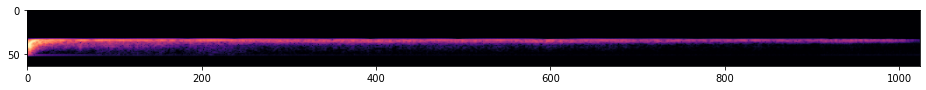

In [9]:
plt.figure(figsize=(16,8))
plt.imshow(normalized_data[36, 0, :, :], cmap='magma')
plt.show()

In [10]:
normalized_data = torch.Tensor(normalized_data.numpy())
normalized_data.shape

torch.Size([584, 2, 64, 1024])

In [11]:
hyperparams = {'n_epochs': 1000, 
               'batch_size': 16,
               'lr': 8e-4, 
               'b1': 0.5, 
               'b2': 0.999, 
               'n_cpu': 8, 
               'latent_dim': 256, 
               'img_size': (64, 1024), 
               'channels': 2,
               'n_critic': 1, 
               'clip_value': 0.01, 
               'sample_interval': 100,
               'save_every': 25}

img_shape = (hyperparams['channels'], hyperparams['img_size'][0], hyperparams['img_size'][1])
cuda = True if torch.cuda.is_available() else False
img_shape

(2, 64, 1024)

In [12]:
os.makedirs("images", exist_ok=True)

In [13]:
#@title Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_channels, out_channels, upsample=True):
            # layers = [nn.Conv2d(in_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False)]
            layers = [nn.ConvTranspose2d(in_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False)]
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            # layers.append(Pixel_norm())
            # layers.append(nn.Conv2d(out_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False))
            layers.append(nn.ConvTranspose2d(out_channels, out_channels, [3, 3], stride=1, padding=[1, 1], bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            # layers.append(Pixel_norm())
            if upsample:
                layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
            return layers

        self.model = nn.Sequential(
            # nn.ZeroPad2d((15, 15, 0, 0)),
            # nn.Conv2d(256, 256, [1, 16], stride=1, bias=False),
            nn.ConvTranspose2d(hyperparams['latent_dim'], 256, [1, 16], stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Pixel_norm(),
            # nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False),
            nn.ConvTranspose2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Pixel_norm(),
            nn.Upsample(scale_factor=2, mode='nearest'), # output shape (None, 256, 2, 32)
            *block(256, 256), # output shape (None, 256, 4, 64)
            *block(256, 256), # output shape (None, 256, 8, 128)
            *block(256, 256), # output shape (None, 256, 16, 256)
            *block(256, 128), # output shape (None, 128, 32, 512)
            *block(128, 64), # output shape (None, 64, 64, 1024)
            *block(64, 32, upsample=False), # output shape (None, 32, 64, 1024)
            # nn.Conv2d(32, 2, [1, 1], stride=1, bias=False),
            nn.ConvTranspose2d(32, 2, [1, 1], stride=1, bias=False),
            nn.Tanh()
            )

    def forward(self, z):
        img = z.view(-1, 256, 1, 1)
        img = self.model(img)
        return img

In [14]:
#@title Simple Generator
class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.pnorm = Pixel_norm()
        self.upscale = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(hyperparams['latent_dim'], 256, [1, 16], stride=1, bias=False)
        self.conv2 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv3 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv4 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv5 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv6 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv7 = nn.Conv2d(256, 128, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv8 = nn.Conv2d(128, 64, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv9 = nn.Conv2d(64, 32, [3, 3], stride=1, padding=[1, 1], bias=False)
        self.conv10 = nn.Conv2d(32, 2, [1, 1], stride=1, bias=False)
        

    def forward(self, z):
        img = z.view(-1, 256, 1, 1)
        img = nn.ZeroPad2d((15, 15, 0, 0))(img)
        img = self.conv1(img)
        img = self.pnorm(self.lrelu(img))
        img = self.conv2(img)
        img = self.pnorm(self.lrelu(img))
        img = self.upscale(img)
        # 2 x 32
        img = self.conv3(img)
        img = self.pnorm(self.lrelu(img))
        img = self.upscale(img)
        # 4 x 64
        img = self.conv4(img)
        img = self.pnorm(self.lrelu(img))
        img = self.upscale(img)
        # 8 x 128
        img = self.conv5(img)
        img = self.pnorm(self.lrelu(img))
        img = self.upscale(img)
        # 16 x 256
        img = self.conv6(img)
        img = self.pnorm(self.lrelu(img))
        img = self.upscale(img)
        # 32 x 512
        img = self.conv7(img)
        img = self.pnorm(self.lrelu(img))
        img = self.upscale(img)
        # 64 x 1024
        img = self.conv8(img)
        img = self.pnorm(self.lrelu(img))
        # 64 x 1024
        img = self.conv9(img)
        img = self.pnorm(self.lrelu(img))
        # 64 x 1024
        img = self.conv10(img)
        img = nn.Tanh()(img)

        return img

In [15]:
#@title Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def block(in_channels, out_channels, downsample=True):
            layers = [nn.Conv2d(in_channels, out_channels, [3, 3], stride=1, padding=[1, 1])]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_channels, out_channels, [3, 3], stride=1, padding=[1, 1]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if downsample:
                layers.append(nn.AvgPool2d(2, 2))
            return layers

        self.model = nn.Sequential(
            nn.Conv2d(2, 32, [1, 1], stride=1),
            *block(32, 32), # output shape (None, 32, 32, 512)
            *block(32, 64), # output shape (None, 64, 16, 256)
            *block(64, 128), # output shape (None, 128, 8, 128)
            *block(128, 256), # output shape (None, 256, 4, 64)
            *block(256, 256), # output shape (None, 256, 2, 32)
            *block(256, 256), # output shape (None, 256, 1, 16)
            Minibatch_std(), # output shape (None, 257, 1, 16)
            *block(257, 256, downsample=False), # output shape (None, 256, 1, 16)
            nn.Flatten(),
            nn.Linear(256*1*16, 1),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [16]:
#@title Simple Discriminator 
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()

        self.downscale = nn.MaxPool2d(2, 2)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.mbs = Minibatch_std()
        self.conv1 = nn.Conv2d(2, 32, [1, 1], stride=1)
        self.conv2 = nn.Conv2d(32, 32, [3, 3], stride=1, padding=[1, 1])
        self.conv3 = nn.Conv2d(32, 64, [3, 3], stride=1, padding=[1, 1])
        self.conv4 = nn.Conv2d(64, 128, [3, 3], stride=1, padding=[1, 1])
        self.conv5 = nn.Conv2d(128, 256, [3, 3], stride=1, padding=[1, 1])
        self.conv6 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1])
        self.conv7 = nn.Conv2d(256, 256, [3, 3], stride=1, padding=[1, 1])
        self.conv8 = nn.Conv2d(257, 256, [3, 3], stride=1, padding=[1, 1])
        self.fc1 = nn.Linear(256*1*16, 1)
        

    def forward(self, img):
        img = self.lrelu(self.conv1(img))
        img = self.lrelu(self.conv2(img))
        img = self.downscale(img)
        # 32 x 512
        img = self.lrelu(self.conv3(img))
        img = self.downscale(img)
        # 16 x 256
        img = self.lrelu(self.conv4(img))
        img = self.downscale(img)
        # 8 x 128
        img = self.lrelu(self.conv5(img))
        img = self.downscale(img)
        # 4 x 64
        img = self.lrelu(self.conv6(img))
        img = self.downscale(img)
        # 2 x 32
        img = self.lrelu(self.conv7(img))
        img = self.downscale(img)
        # 1 x 16
        img = self.mbs(img)
        img = self.lrelu(self.conv8(img))
        img = nn.Flatten()(img)
        validity = self.fc1(img)

        return validity

In [17]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [18]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = SimpleGenerator()
discriminator = SimpleDiscriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [19]:
# Configure data loader
dataloader = torch.utils.data.DataLoader(normalized_data, batch_size=hyperparams['batch_size'], shuffle=True)

In [27]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(),
                               lr=hyperparams['lr'],
                               betas=(hyperparams['b1'], hyperparams['b2'])
                               )
optimizer_D = torch.optim.Adam(discriminator.parameters(),
                               lr=hyperparams['lr'],
                               betas=(hyperparams['b1'], hyperparams['b2'])
                               )

In [21]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [22]:
def save_model(G, D, opt_G, opt_D, g_loss, d_loss, epoch, pix=False):
    os.makedirs("saved_models", exist_ok=True)
    if pix:
        path = 'saved_models/SGANSynth_Pix_{}.pth'
    else:
        path = 'saved_models/SGANSynth_{}.pth'
    torch.save({
                'epoch': hyperparams['n_epochs'],
                'generator_state_dict': G.state_dict(),
                'discriminator_state_dict': D.state_dict(),
                'optimizer_G_state_dict': opt_G.state_dict(),
                'optimizer_D_state_dict': opt_D.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss,
                }, path.format(epoch + 1))


def load_model(D, G, opt_D, opt_G, epoch, path: str='saved_models/GANSynth_{}.pth', pix=False):
    if pix:
        path = 'saved_models/SGANSynth_Pix_{}.pth'
    checkpoint = torch.load(path.format(epoch))
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    G.load_state_dict(checkpoint['generator_state_dict'])
    opt_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    opt_G.load_state_dict(checkpoint['optimizer_G_state_dict'])

    D.eval()
    G.eval()
    # - or -
    # modelA.train()
    # modelB.train()

In [ ]:
# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(hyperparams['n_epochs']):
    for i, imgs in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], hyperparams['latent_dim']))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % hyperparams['n_critic'] == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            if batches_done % hyperparams['sample_interval'] == 0:
                save_image(fake_imgs.data[:16, 0, :, :].unsqueeze(1), "images/%d.png" % batches_done, nrow=4, )# normalize=True)

                display.clear_output(wait=True)
                """
                fig = plt.figure(figsize=(16,4))
                fig.tight_layout()
                
                for i in range(16):
                    plt.subplot(4, 4, i+1)
                    plt.imshow(fake_imgs.data[i, 0, :, :].to('cpu').numpy(), cmap='magma')
                    # plt.plot(waves[i, :, 0])
                    plt.axis('off')
                
                plt.savefig("images/%d.png" % batches_done)
                plt.show()
                """

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, hyperparams['n_epochs'], i, len(dataloader), d_loss.item(), g_loss.item())
            )
            
            batches_done += hyperparams['n_critic']
    
    # Save model:
    if (epoch + 1) % hyperparams['save_every'] == 0:
        save_model(G=generator,
                  D=discriminator,
                  opt_D=optimizer_D,
                  opt_G=optimizer_G,
                  g_loss=g_loss,
                  d_loss=d_loss,
                  epoch=epoch,
                  pix=True)

[Epoch 10/1000] [Batch 30/37] [D loss: -16.452456] [G loss: 101.837875]
[Epoch 10/1000] [Batch 31/37] [D loss: -17.280170] [G loss: 30.907572]
[Epoch 10/1000] [Batch 32/37] [D loss: -14.179173] [G loss: 92.456627]
[Epoch 10/1000] [Batch 33/37] [D loss: -14.169432] [G loss: -119.396286]
[Epoch 10/1000] [Batch 34/37] [D loss: -15.208435] [G loss: -106.263412]
[Epoch 10/1000] [Batch 35/37] [D loss: -13.215623] [G loss: 14.535150]
[Epoch 10/1000] [Batch 36/37] [D loss: -14.159986] [G loss: 238.396301]
[Epoch 11/1000] [Batch 0/37] [D loss: -17.782356] [G loss: 288.035858]
[Epoch 11/1000] [Batch 1/37] [D loss: -16.399574] [G loss: -50.164707]
[Epoch 11/1000] [Batch 2/37] [D loss: -15.234079] [G loss: -291.315308]
[Epoch 11/1000] [Batch 3/37] [D loss: -15.893797] [G loss: -443.580872]
[Epoch 11/1000] [Batch 4/37] [D loss: -18.097137] [G loss: -447.068695]
[Epoch 11/1000] [Batch 5/37] [D loss: -17.641918] [G loss: -652.280518]
[Epoch 11/1000] [Batch 6/37] [D loss: -17.662903] [G loss: -731.737

In [ ]:
save_model(G=generator,
          D=discriminator,
          opt_D=optimizer_D,
          opt_G=optimizer_G,
          g_loss=g_loss,
          d_loss=d_loss,
          epoch=epoch,
          pix=True)

In [23]:
load_model(D=discriminator,
           G=generator,
           opt_D=optimizer_D,
           opt_G=optimizer_G,
           epoch=825,
           pix=True)

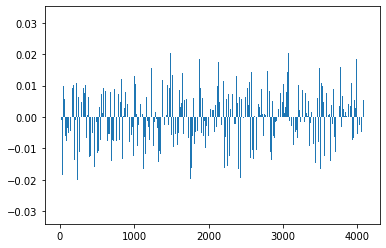

[4096]

In [ ]:
#plt.bar(generator.state_dict()[np.arange, 'model.0.weight'])
plt.bar(np.arange(4096), discriminator.state_dict()['model.37.weight'][0, :].to('cpu'))
plt.show()
list(discriminator.state_dict()['model.37.weight'][0, :].to('cpu').size())

Model's state_dict:
model.0.weight 	 [32, 2, 1, 1]
model.0.bias 	 [32]
model.1.weight 	 [32, 32, 3, 3]
model.1.bias 	 [32]
model.3.weight 	 [32, 32, 3, 3]
model.3.bias 	 [32]
model.6.weight 	 [64, 32, 3, 3]
model.6.bias 	 [64]
model.8.weight 	 [64, 64, 3, 3]
model.8.bias 	 [64]
model.11.weight 	 [128, 64, 3, 3]
model.11.bias 	 [128]
model.13.weight 	 [128, 128, 3, 3]
model.13.bias 	 [128]
model.16.weight 	 [256, 128, 3, 3]
model.16.bias 	 [256]
model.18.weight 	 [256, 256, 3, 3]
model.18.bias 	 [256]
model.21.weight 	 [256, 256, 3, 3]
model.21.bias 	 [256]
model.23.weight 	 [256, 256, 3, 3]
model.23.bias 	 [256]
model.26.weight 	 [256, 256, 3, 3]
model.26.bias 	 [256]
model.28.weight 	 [256, 256, 3, 3]
model.28.bias 	 [256]
model.32.weight 	 [256, 257, 3, 3]
model.32.bias 	 [256]
model.34.weight 	 [256, 256, 3, 3]
model.34.bias 	 [256]
model.37.weight 	 [1, 4096]
model.37.bias 	 [1]


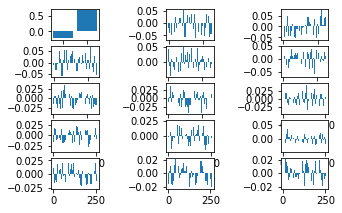

In [ ]:
print("Model's state_dict:")
i = 0
for param_tensor in discriminator.state_dict():
    dims = list(discriminator.state_dict()[param_tensor].to('cpu').size())
    print(param_tensor, "\t", dims)

    if len(dims) == 4:
        plt.subplot(6, 6, i+1)
        plt.bar(np.arange(dims[1]),
                discriminator.state_dict()[param_tensor][16, :, 0, 0].to('cpu'))
    
    i += 1

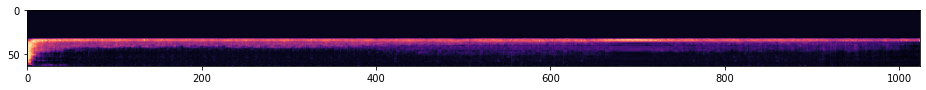

In [24]:
z = Variable(Tensor(np.random.normal(0, 1, (64, hyperparams['latent_dim']))), requires_grad=False)
g = generator(z).detach().to('cpu').numpy()

plt.figure(figsize=(16,8))
plt.imshow(g[0, 0, :, :], cmap='magma', )
plt.show()

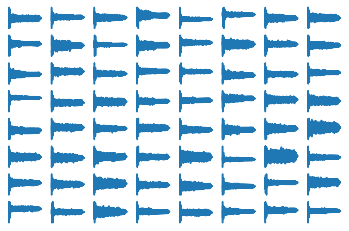

In [26]:
wavs = g.transpose([0, 2, 3, 1])
wavs = spec_gr.melspecgrams_to_waves(wavs).numpy()
#plt.figure(figsize=(12,6))
#plt.plot(wavs[2])
#plt.show()

for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.plot(wavs[i, :, 0])
    plt.axis('off')

with open('images/gen.npy', 'wb') as f:
  np.save(f, wavs)